## Applied - Question 9

This question will apply the random forest to the OJ dataset.

The data contains 1070 purchases where the customer either purchased Citrus Hill 
or Minute Maid Orange Juice. A number of characteristics of the customer 
and product are recorded.

A data frame with 1070 observations on the following 18 variables.

1. Purchase: A factor with levels CH and MM indicating whether the customer purchased 
Citrus Hill or Minute Maid Orange Juice
2. WeekofPurchase: Week of purchase
3. StoreID: Store ID
4. PriceCH: Price charged for CH
5. PriceMM: Price charged for MM
6. DiscCH: Discount offered for CH
7. DiscMM: Discount offered for MM
8. SpecialCH: Indicator of special on CH
9. SpecialMM: Indicator of special on MM
10. LoyalCH: Customer brand loyalty for CH
11. SalePriceMM: Sale price for MM
12. SalePriceCH: Sale price for CH
13. PriceDiff: Sale price of MM less sale price of CH
14. Store7: A factor with levels No and Yes indicating whether the sale is at Store 7
15. PctDiscMM: Percentage discount for MM
16. PctDiscCH: Percentage discount for CH  
17. ListPriceDiff: List price of MM less list price of CH  
18. STORE

#### Import block

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from IPython.display import Image
from six import StringIO

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,\
    export_graphviz
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, \
    RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report

%matplotlib inline
plt.style.use('seaborn-white')

Define the print_tree function

In [5]:
# This function return the tree image 
def print_tree(estimator, features, class_names=None, filled=True):    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features,
                    class_names=class_names, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

(a) Create a training set with 800 random samples and a test set with the rest.

In [6]:
# Read data
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}OJ.csv')

# transform categorical into numeric levels
df.Store7 = df.Store7.astype('category').cat.codes

# Set up X and y
X = df.drop('Purchase', axis=1)
y = df.Purchase

# Train and test set split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=800, random_state=1)

# First Look
X.head()

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


(b) Fit classification tree. We do not tune at this point.

Training accuracy is 99%. This figures means little in practice however. There are 
13 terminal leaf nodes which are white color in the graph.

In [7]:
# Defind the print_cm function from chapter 3
def print_cm(y_test, y_pred, model):
	cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index=model.classes_, 
                         columns=model.classes_)
	cm_df.index.name = 'Predicted'
	cm_df.columns.name = 'True'
	print('Confusion Matrix \n', cm_df, '\n\nClassification report \n', 
          classification_report(y_test, y_pred, digits=3))
    

Confusion Matrix 
 True        CH   MM
Predicted          
CH         495    7
MM           1  297 

Classification report 
               precision    recall  f1-score   support

          CH      0.986     0.998     0.992       496
          MM      0.997     0.977     0.987       304

    accuracy                          0.990       800
   macro avg      0.991     0.987     0.989       800
weighted avg      0.990     0.990     0.990       800



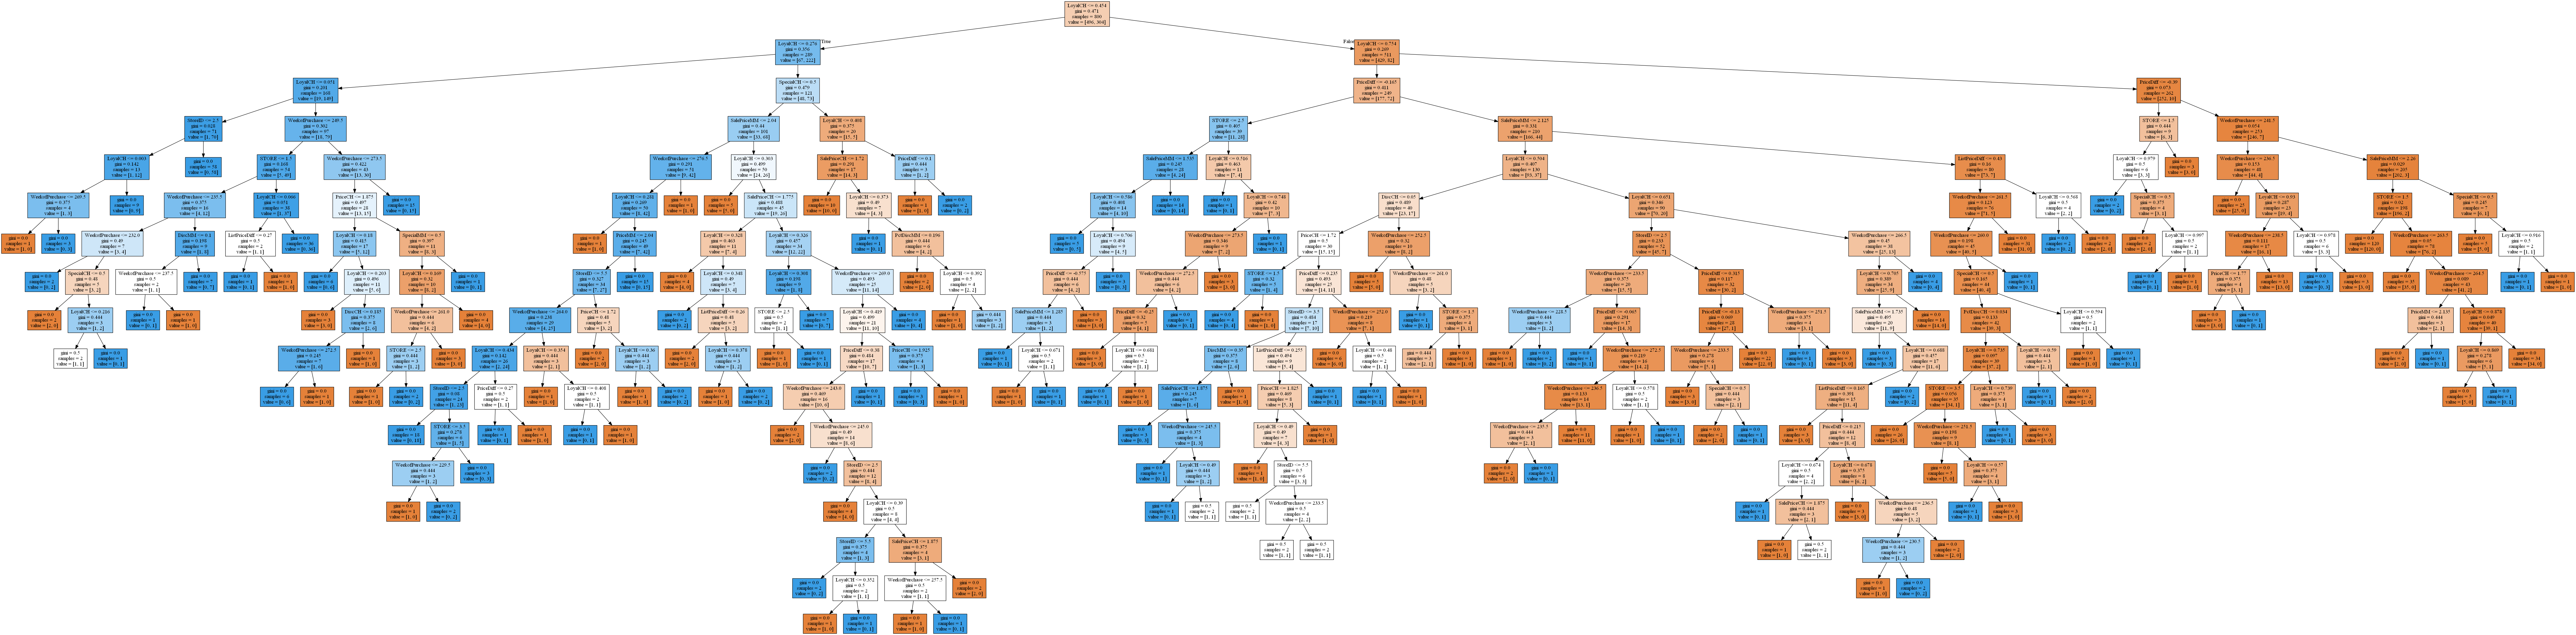

In [8]:
# Classifier tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_train)

# Confusion matrix
print_cm(y_train, y_pred, clf)

# Print tree
graph = print_tree(clf, X.columns)
Image(graph.create_png())

(c) Interpret based on the graph

(d) Above

(e) Now we want to see how the model perform with test data. The result is much worse than
the training prediction which is expected.

The accuracy is around 75.6% -> test error rate of 24.4%

In [9]:
# Prediction using test data
y_pred = clf.predict(X_test)

# Confusion matrix
print_cm(y_test, y_pred, clf)

Confusion Matrix 
 True        CH  MM
Predicted         
CH         134  41
MM          23  72 

Classification report 
               precision    recall  f1-score   support

          CH      0.766     0.854     0.807       157
          MM      0.758     0.637     0.692       113

    accuracy                          0.763       270
   macro avg      0.762     0.745     0.750       270
weighted avg      0.762     0.763     0.759       270



(f) - (h) Find the optimal tree size using CV

Note: We are using accuracy as the metric so the higher then number the better.

First we get the number for running the training error CV

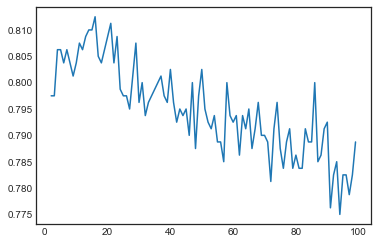

In [10]:
# Set up 10 fold CV and parameters for plot
kf = KFold(n_splits=10, shuffle=True, random_state=1)
acc = []
leaf_range = np.arange(2,100,1)

# Run CV
for i in leaf_range:
    # Fit tree
    clf = DecisionTreeClassifier(max_leaf_nodes=i)
    
    # Cross validated error
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy')
    acc.append(score.mean())

# Plot
plt.plot(np.arange(2,100,1), acc)

Get the number for testing error CV.

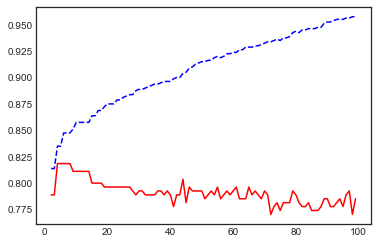

In [11]:
# parameter for plot
train_score = []
test_score = []

# Fit tree and CV
for i in leaf_range:
    # Fit tree
    clf = DecisionTreeClassifier(max_leaf_nodes=i).fit(X_train, y_train)
    
    # CV
    train_score.append(clf.score(X_train, y_train))
    test_score.append(clf.score(X_test, y_test))
    
# Plot
plt.plot(leaf_range, train_score, c='b', linestyle='--')
plt.plot(leaf_range, test_score, c='r', linestyle='-')
plt.legend()